## Utilities and libraries installation

In [ ]:
%%shell
jupyter nbconvert --to html /content/Boston_Airbnb_Open_Data.ipynb

In [ ]:
!pip install sentence-transformers

In [ ]:
!pip install lancedb

In [ ]:
!pip install pydantic

In [ ]:
!pip install tiktoken

In [ ]:
!pip install openai==0.28

In [6]:
from google.colab import drive
import openai
import pandas as pd
import seaborn as sns
import lancedb
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
from lancedb.pydantic import vector, LanceModel
from sklearn import preprocessing
from sklearn.cluster import KMeans
import tiktoken

pd.set_option('display.max_colwidth', None)

## Business understanding

The objective of the present work is to answer the following three business questions:

 - Describe the vibe for each neighborhood, bassed on the listing descriptions

 - Study the busiest times of the year to visit Boston and how much the prices spike

 - Based on the characteristics of the listings, find the differences in  availability and prices, uf any exists

## Data understanding

Fortunately, with the data provided by Airbnb it is possible to answer all of them. In particular, we will use the following datasets (available at https://www.kaggle.com/datasets/airbnb/boston):

  - listings.csv: It contains the master data for the listings, with a lot of detail. We wiil be only interested in the following columns:

      - neighborhood_overview: defines a brief description of neighborhood the listing is
      - neighborhood_cleansed:neighborhood for the listing
      - property_type: if it is an apartment house, villa and so on
      - room_type: if it is a private room, shared room, or a whole apartment
      - accommodates: number of accommodates
      - bathrooms: number of bathrooms
      - beds: number of beds
      - bed_type: If it is a real bed, a couch and so on
  
  - calendar.csv: It contains a daily snapshot of the listing, including the following columns:
    - available: Whether the listing is available
    - The price the listing had the day of the snapshot

###Gathering data

Once we have identified the required data, we will gather the data and take a first look at it:

In [8]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
data_dir = '/content/gdrive/MyDrive/listings.csv'
boston_airbnb_df = pd.read_csv(data_dir)

In [10]:
data_dir = '/content/gdrive/MyDrive/calendar.csv'
boston_airbnb_calendar_df = pd.read_csv(data_dir)

### Missing value study

We will inspect the data focusing on the column we are interested in. Let´s take a look to the listing dataset:

In [12]:
boston_airbnb_df[['description', 'neighborhood_overview', 'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type']].isnull().sum()

description                  0
neighborhood_overview     1415
neighbourhood_cleansed       0
property_type                3
room_type                    0
accommodates                 0
bathrooms                   14
bedrooms                    10
beds                         9
bed_type                     0
dtype: int64

And how many rows the dataset has:

In [15]:
print("number of rows for the boston airbnb listing master data set: {0}".format(boston_airbnb_df.shape[0]))

number of rows for the boston airbnb listing master data set: 3585


From the above data, we can see there is only 4 columns with null values and three of them has a small percentage of null w.r.t. the total size of the data set. Therefore, it will reasonable to impute the data by using some elementary
method like the mode or the median. Let´s investigate whether it is necessary and possible to impute the missing values for the neighneighborhood_overview column:

The neighboorhood overview is necessary for the creation of the neighborhood´s vibe? Do we have enough data for it?

In [17]:
boston_airbnb_df[boston_airbnb_df['neighborhood_overview'].notnull()].groupby(['neighbourhood_cleansed']).size()

neighbourhood_cleansed
Allston                    146
Back Bay                   181
Bay Village                 19
Beacon Hill                131
Brighton                   105
Charlestown                 53
Chinatown                   46
Dorchester                 144
Downtown                   108
East Boston                 87
Fenway                     148
Hyde Park                   15
Jamaica Plain              246
Leather District             5
Longwood Medical Area        6
Mattapan                    14
Mission Hill                58
North End                   88
Roslindale                  42
Roxbury                     92
South Boston               114
South Boston Waterfront     41
South End                  225
West End                    32
West Roxbury                24
dtype: int64

As we can see, there is reasonable raw description for each neighborhood, therefore we will keep it simple in a first stage and not impute the missing values.

In [23]:
boston_airbnb_calendar_df.isnull().sum()

listing_id         0
date               0
available          0
price         665853
dtype: int64

In [24]:
print("number of rows for the boston airbnb calendar data set: {0}".format(boston_airbnb_calendar_df.shape[0]))

number of rows for the boston airbnb calendar data set: 1308890


In this case, there is a los of missing values in the price column. Let´s investigate why this is the case:

In [25]:
boston_airbnb_calendar_df[boston_airbnb_calendar_df['price'].isna()]

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN
...,...,...,...,...
1308885,14504422,2016-09-10,f,NaN
1308886,14504422,2016-09-09,f,NaN
1308887,14504422,2016-09-08,f,NaN
1308888,14504422,2016-09-07,f,NaN


The result suggest there is only missing values when the listing is not available, which is quite reasonable. Let´s verify with a simple query:

In [26]:
boston_airbnb_calendar_df[boston_airbnb_calendar_df['price'].isna() & boston_airbnb_calendar_df['available'] == 't']

,listing_id,date,available,price


Therefore the missing value in this particular case is due to a business rule, there can not be a price, if the listing is not available.

### General exploration

In [68]:
boston_airbnb_df[['id', 'description', 'neighborhood_overview', 'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type']].head()

,id,description,neighborhood_overview,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type
0,12147973,"Cozy, sunny, family home. Master bedroom high ceilings. Deck, garden with hens, beehives & play structure. Short walk to charming village with attractive stores, groceries & local restaurants. Friendly neighborhood. Access public transportation. The house has an open and cozy feel at the same time. The living room has a flat screen TV. The kitchen has all you need for cooking. We prefer you buy your food but can use the organic oils, herbs, etc. The yard can be seen from sitting room and when the weather allows, the yard is a place children can lose themselves in a safe way. We have 2 bee hives, 6 hens fenced in (sometimes they get out of their coop area & into the yard), 2 rabbits in a hutch and play structure. You will have access to 2 bedrooms, a living room, kitchen, bathrooms, and yard. Roslindale is quiet, convenient and friendly. For Southern food try Redd's in Rozzie. Italian Delfino's or Sophia's Grotto are great. Birch St Bistro has nice atmostphere--a little pric","Roslindale is quiet, convenient and friendly. For Southern food try Redd's in Rozzie. Italian Delfino's or Sophia's Grotto are great. Birch St Bistro has nice atmostphere--a little pricier. If you are cooking the Fish Market has fresh fish daily; Tony's makes his own sausages and has Italian foods; for a wide variety of delicious cheeses and chocolates go to the Cheese Cellar on Birch St.",Roslindale,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed
1,3075044,"Charming and quiet room in a second floor 1910 condo building. The room has a full size bed, darkening curtains, window A/C unit. It's quiet because it's in the back of the house. Shared bathroom. Guests can use kitchen, living room. Pet friendly. Small but cozy and quite room with a full size bed. Ample street parking. Apt has one more bedroom (which I use) and large living space and kitchen that you can use. Possibility to do laundry. Two porches. If I am at home, I am likely working in my home office, which is a separate room. I can help you settle in and give you tips and directions on the neighborhood and Boston. The room is in Roslindale, a diverse and primarily residential neighborhood of Boston. It's well connected via public transportation to other neighborhoods and easy to access by car. Roslindale Square is a nice business district with supermarkets. banks, a bakery, etc. (See my Guidebook for some recommendations). The Arnold Arboretum is just steps away. Plenty of safe s","The room is in Roslindale, a diverse and primarily residential neighborhood of Boston. It's well connected via public transportation to other neighborhoods and easy to access by car. Roslindale Square is a nice business district with supermarkets. banks, a bakery, etc. (See my Guidebook for some recommendations). The Arnold Arboretum is just steps away.",Roslindale,Apartment,Private room,2,1.0,1.0,1.0,Real Bed
2,6976,"Come stay with a friendly, middle-aged guy in the safe and quiet Roslindale neighborhood of Boston. You will have you own clean, furnished room (with cable TV, Wi-Fi, and a desk to work at) in an apartment that is filled with Mexican folk art. This is a well-maintained two-family house built in the 1940s. My apartment is on the second floor. This is a pet and smoke-free apartment. PRICE: Price includes ALL utilities (heat, electricity, Wi-Fi, cable TV, air conditioner), parking in street, and use of back yard. NO SMOKING indoors or outside. Note that the bed is a size ""Full"" mattress, not a Queen or a King. This is ideal for one guest, but if it is two people traveling together, you can fit two in the bed, or the second person can sleep in the living room, on the long couch. (Not a fold-out couch, but comfortable). Additional fee for the second person is $20. The price listed is for one person. I offer discounted rates for stays of one week or longer. Guests get free

In [18]:
boston_airbnb_df[['description', 'neighborhood_overview', 'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type']].describe()

,accommodates,bathrooms,bedrooms,beds
count,3585.000000,3571.000000,3575.000000,3576.000000
mean,3.041283,1.221647,1.255944,1.609060
std,1.778929,0.501487,0.753060,1.011745
min,1.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000
50%,2.000000,1.000000,1.000000,1.000000
75%,4.000000,1.000000,2.000000,2.000000
max,16.000000,6.000000,5.000000,16.000000


In [22]:
boston_airbnb_df[['description', 'neighborhood_overview', 'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type']].dtypes

description                object
neighborhood_overview      object
neighbourhood_cleansed     object
property_type              object
room_type                  object
accommodates                int64
bathrooms                 float64
bedrooms                  float64
beds                      float64
bed_type                   object
dtype: object

In [28]:
boston_airbnb_calendar_df.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

The data types are not correct for the columns date, available and price.

## Data preparation

In this section, we will create a cleaned version of the raw data. We will impute the missing values detected in previos section and correct the erroneous data types, as well as some basic transformations of general use.

### Imputing missing values

In [69]:
listing_df = boston_airbnb_df[['id', 'description', 'neighborhood_overview', 'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type']].copy()

In [70]:
listing_df['bathrooms'].fillna((listing_df['bathrooms'].mode()[0]), inplace=True)
listing_df['bedrooms'].fillna((listing_df['bedrooms'].mode()[0]), inplace=True)
listing_df['beds'].fillna((listing_df['beds'].mode()[0]), inplace=True)
listing_df['property_type'].fillna((listing_df['property_type'].mode()[0]), inplace=True)

In [71]:
listing_df.isnull().sum()

id                           0
description                  0
neighborhood_overview     1415
neighbourhood_cleansed       0
property_type                0
room_type                    0
accommodates                 0
bathrooms                    0
bedrooms                     0
beds                         0
bed_type                     0
dtype: int64

### Data types corrections

In [72]:
boston_airbnb_calendar_normalized_df = boston_airbnb_calendar_df.copy()

In [73]:
# Price column normalization
price_normalized = [x if pd.isna(x) else x[1:].replace(',', '') for x in boston_airbnb_calendar_df['price']]
boston_airbnb_calendar_normalized_df['price_normalized'] = price_normalized
boston_airbnb_calendar_normalized_df['price_normalized'] = boston_airbnb_calendar_normalized_df['price_normalized'].astype(float)


# Available column normalization
available_normalized = [True if x == 't' else False for x in boston_airbnb_calendar_df['available']]
boston_airbnb_calendar_normalized_df['available_normalized'] = available_normalized

# date column normalization
boston_airbnb_calendar_normalized_df['date_normalized'] = pd.to_datetime(boston_airbnb_calendar_normalized_df['date'])


### Creation of date time columns

In [74]:
# Creation of a month-year column
month_year = [x[:7] for x in boston_airbnb_calendar_df['date']]
boston_airbnb_calendar_normalized_df['month_year'] = month_year
boston_airbnb_calendar_normalized_df['month_year'] = pd.to_datetime(boston_airbnb_calendar_normalized_df['month_year'], format='%Y-%m')

In [40]:
boston_airbnb_calendar_normalized_df.dtypes

listing_id                       int64
date                            object
available                       object
price                           object
price_normalized               float64
available_normalized              bool
date_normalized         datetime64[ns]
month_year              datetime64[ns]
dtype: object

## Data modelling

In [ ]:
api_key = "YOUR-API-KEY-HERE"
openai.api_key = api_key

We leverage the power of LLM for generating the vibe of each neighborhood from the descriptions. The steps that we will take follow and standard RAG pattern:

  - Generate the embeddings for the descriptions of the neighborhood and sotre it in a vector database
  - For each question about the neighboord`s vibe, retrieve the most relevant context
  - Generate an appropiate prompt and let LLM resolve the question with the provided context

In [ ]:
api_key = "YOUR-API-KEY-HERE"
openai.api_key = api_key

Here are the auxiliar functions that will be used in this section:

In [ ]:
def generate_embeddings(MODEL_NAME, data):
  """

  Args:
    MODEL_NAME: LLM model used to generate the embeddings
    data: List of string from which to abtain the embeddgins

  Returns:

  """


  model = SentenceTransformer(MODEL_NAME)
  embeddings = model.encode(data)
  return embeddings

In [ ]:
def create_table_to_database(table_name, table_schema, db_instance):
  """

  Args:
    table_name: table name for the table to be created
    table_schema: table schema for the table to be created
    db_instance: db instance on whoch we crate the table
  """
  db_instance.drop_table(table_name, ignore_missing=True)
  table = db_instance.create_table(table_name, schema=table_schema)
  return table

In [ ]:
def get_prompt_neighbourhood_vibe(vibe_question, neighborhood_descriptions, max_tokens=4096):
  """

  Args:
    vibe_question: a formulation for the vibe of the neighborhood
    neighborhhod: neighborhood name
    max_tokens: maximum number of tokens allowed for the propmt.
  """

  propmt = """

  Given the context provided below, generate a description for the vibe of the neighborhood.
  The information about the neighborhoud must be extracted from the context and it is not allowed to include any information that does not appear in the context.

  Context: {}


  question: {}
  Neighborhood description:

  """

  tokenizer = tiktoken.get_encoding('cl100k_base')
  current_number_tokens = len(tokenizer.encode(vibe_question)) + len(tokenizer.encode(propmt))
  l_context = []

  # Construct the string in a format suitable for the prompt template

  for text in neighborhood_descriptions:
    current_number_tokens += len(tokenizer.encode(text))
    if current_number_tokens <= max_tokens:
      l_context.append(text)
    else:
      break

  context = '\n\n###\n\n'.join(l_context)

  return propmt.format(context, vibe_question)

In [ ]:
def generate_answer(prompt_template, max_tokens=2024):
    """

    Args:
      prompt_template: prompt template to be sent via API to OpenAI
      max_tokens: maximum number of tokens allowed for the propmt.

    Returns:

    """
    try:
        # Calling the OpenAI API with a system message and our prompt in the user message content
        # Use openai.ChatCompletion.create for openai < 1.0
        # openai.chat.completions.create for openai > 1.0
        response = openai.ChatCompletion.create(
          model="gpt-3.5-turbo",
          messages=[
          {
            "role": "user",
            "content": prompt_template
          }
          ],
        temperature=1,
        max_tokens=max_tokens,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
        )
        # The response is a JSON object containing more information than the generated review. We want to return only the message content
        return response.choices[0].message.content
    except Exception as e:
        return f"An error occurred: {e}"

In [ ]:
def generate_neighborhood_vibes(neighboods, neighbood_descriptions, neighborhood_table, max_tokens = 1000):
  """

  Args:
    neighboods: set of neighborhoods
    neighbood_descriptions: list of neighborhood descriptions
    neighborhood_table: neghborhood data base table
    max_tokens: max tokens allowed for the propmt
  """

  responses = []
  for neighborhood in neighboods:
    question = 'Which is the vibe for the {} neighborhood?'
    question = question.format(neighborhood)

    # generate embedding for the question
    question_embedding = generate_embeddings(MODEL_NAME, [question])[0]


    # prompt generation
    filter = "neighborhood == '{}'".format(neighborhood)
    top_k_best = neighborhood_table.search(question_embedding).where(filter).metric('cosine').limit(1000000).to_pandas()
    neighborhood_descriptions = list(top_k_best['description'])

    prompt = get_prompt_neighbourhood_vibe(question, neighborhood_descriptions, max_tokens=max_tokens)


    # Call to OpenAI in order to get the response
    answer = generate_answer(prompt, max_tokens=max_tokens)
    responses.append((neighborhood, answer))
  return responses

### Generation of the vector database


In [ ]:
# Creation of the database
db = lancedb.connect('~/.lancedb')

In [ ]:
# Creation of the table
table_name = 'neighborhood_description'

# Creation of the schema for the table
class NeighborhoodOverview(LanceModel):
  vector: vector(384)
  neighborhood:str
  description: str

neighborhood_table = create_table_to_database(table_name, NeighborhoodOverview, db)

In [44]:
# Create data to populate the database
neighbood_descriptions = list(listing_df[listing_df['neighborhood_overview'].notnull()]['neighborhood_overview'])
neighboods = list(listing_df[listing_df['neighborhood_overview'].notnull()]['neighbourhood_cleansed'])


In [ ]:
# Generation of the embeddings
MODEL_NAME = 'paraphrase-MiniLM-L6-v2'
embeddings = generate_embeddings(MODEL_NAME, neighbood_descriptions)

In [ ]:
# Creation of a list in order to poputale the negihborhood table data base
neighborhoodinfo = []
for neighborhood_desc, neighborhhood, embedding in zip(neighbood_descriptions, neighboods, list(embeddings)):
  neighborhoodinfo.append(NeighborhoodOverview(
      vector=embedding,
      neighborhood=neighborhhood,
      description=neighborhood_desc
    )
  )

In [ ]:
# Populate the database table
neighborhood_table.add(neighborhoodinfo)

### Generation of the vibes description for the neighborhoods

In [ ]:
### BLOCK COMMENTED TO AVOID UNNECESARY CALL TO OPENAI API, INCURRING IN AN EXTRA COST ###


# Call to OpenAI to generate the vibes from the neighborhood descriptions, using prompt engineering techniques

#neighborhood_vibes = generate_neighborhood_vibes(neighboods, neighbood_descriptions, neighborhood_table)

# Creation of a dataframe to store the results

#t_neighborhoods = []
#t_neighborhood_vibes = []
#for t in neighborhood_vibes:
#  t_neighborhoods.append(t[0])
#  t_neighborhood_vibes.append(t[1])


#neighborhood_vibes_df = pd.DataFrame()
#neighborhood_vibes_df['neighborhood'] = t_neighborhoods
#neighborhood_vibes_df['neighborhood_vibe'] = t_neighborhood_vibes

# Persistence of the results to avoid unnecesary calls to Opean AI API

#neighborhood_vibes_df.to_csv('neighborhood_vibes.csv', index=False)

### Question 2

In this section we will create two temporal series in a month-year basis, representing:

  - the percentage of availability for the listings
  - The average price of listings


The idea is to study the two series in order to see the relationship between them, if any.

In [49]:
# Block of calculations for the time series
t_df_boston_my = boston_airbnb_calendar_normalized_df.groupby(['month_year']).size().reset_index(name="total_count")
t_df_boston_mya = boston_airbnb_calendar_normalized_df.groupby(['month_year', 'available_normalized']).size().reset_index(name="count")
t_df_boston_available = pd.merge(t_df_boston_my, t_df_boston_mya, on='month_year', how='inner')
t_df_boston_available['availability_perc'] = t_df_boston_available['count'] / t_df_boston_available['total_count']
t_df_boston_available = t_df_boston_available[t_df_boston_available['available_normalized'] == True]

t_df_boton_price = boston_airbnb_calendar_normalized_df[boston_airbnb_calendar_normalized_df['available_normalized'] == True].groupby(['month_year'])['price_normalized'].sum().reset_index(name="total_price")

q1_time_series_df = pd.merge(t_df_boston_available, t_df_boton_price, on='month_year', how='inner')
q1_time_series_df['avg_price'] = q1_time_series_df['total_price'] / q1_time_series_df['count']
q1_time_series_df.set_index('month_year', inplace=True)

# Remove data from temporal datasets
t_df_boston_my[0:0]
t_df_boston_mya[0:0]
t_df_boston_available[0:0]
t_df_boton_price[0:0]

,month_year,total_price


The busiest times are from april to september, and the prices spikes in a range from 15 - 70 dollars, depending on the availavitity.

### question 3

In this sections, we will leverage the k-means model to create calculate the group of each listing.

In [52]:
listing_characteristics = listing_df[['property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type']].copy()

In [53]:
listing_chracteristics_norm = pd.get_dummies(listing_characteristics, columns=['property_type', 'room_type', 'bed_type'])

In [54]:
scaler = preprocessing.MinMaxScaler()
listing_chracteristics_norm[['accommodates', 'bathrooms', 'bedrooms', 'beds']] = scaler.fit_transform(listing_chracteristics_norm[['accommodates', 'bathrooms', 'bedrooms', 'beds']])

In [55]:
listing_chracteristics_norm.head()

,accommodates,bathrooms,bedrooms,beds,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Camper/RV,property_type_Condominium,property_type_Dorm,...,property_type_Townhouse,property_type_Villa,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
0,0.200000,0.250000,0.4,0.1875,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
1,0.066667,0.166667,0.2,0.0625,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
2,0.066667,0.166667,0.2,0.0625,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
3,0.200000,0.166667,0.2,0.1250,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
4,0.066667,0.250000,0.2,0.1250,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True


In [56]:
# Over a number of different cluster counts...
scores = []
centers = list(range(2,10))
    # run k-means clustering on the data and...
for center in centers:
    print("Processing k means with n_clusters: {}".format(center))
    kmeans = KMeans(n_clusters=center, n_init=20)
    model = kmeans.fit(listing_chracteristics_norm)
    # compute the average within-cluster distances.
    score = np.abs(model.score(listing_chracteristics_norm))
    scores.append(score)

Processing k means with n_clusters: 2
Processing k means with n_clusters: 3
Processing k means with n_clusters: 4
Processing k means with n_clusters: 5
Processing k means with n_clusters: 6
Processing k means with n_clusters: 7
Processing k means with n_clusters: 8
Processing k means with n_clusters: 9


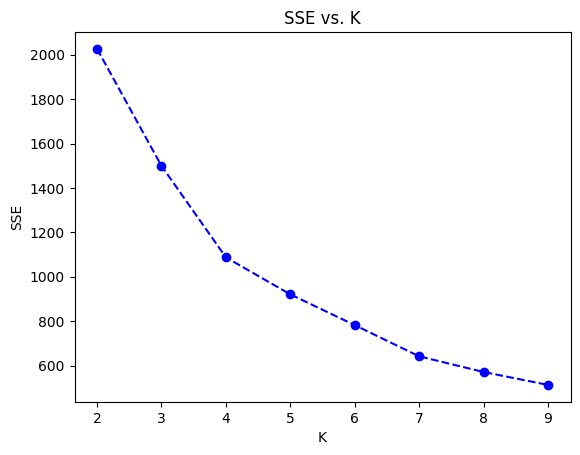

In [57]:
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [58]:
# cluster predictions for the general population demographics data.
selected_n_clusters = 4
kmeans = KMeans(n_clusters=selected_n_clusters, n_init=20, random_state=999)
model = kmeans.fit(listing_chracteristics_norm)
kmeans_pred = model.predict(listing_chracteristics_norm)

In [59]:
set(kmeans_pred)

{0, 1, 2, 3}

In [60]:
listing_characteristics['cluster'] = kmeans_pred

In [61]:
listing_characteristics.head()

,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,cluster
0,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,3
1,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,1
2,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,1
3,House,Private room,4,1.0,1.0,2.0,Real Bed,2
4,House,Private room,2,1.5,1.0,2.0,Real Bed,2


Finally, in this section we will perform the calculations needed for the time series used in the question 2, but also including the group dimension.

In [79]:
# Enrich the listing dataset with the cluster it belongs to
listing_df['cluster'] = kmeans_pred
cluster_dict = {0: 'Whole apartment', 1: 'Apartement private room', 2: 'Home private room', 3: 'Others entier property'}
cluster_description = [cluster_dict[x] for x in listing_df['cluster']]
listing_df['cluster_description'] = cluster_description

In [84]:
# Same calculus as in the previous question, including the cluster dimension
t_calendar_inner_listing_df = listing_df.merge(boston_airbnb_calendar_normalized_df, left_on='id', right_on='listing_id', how='inner')
t_df_boston_my = t_calendar_inner_listing_df.groupby(['month_year', 'cluster_description']).size().reset_index(name="total_count")
t_df_boston_mya = t_calendar_inner_listing_df.groupby(['month_year', 'cluster_description', 'available_normalized']).size().reset_index(name="count")
t_df_boston_available = pd.merge(t_df_boston_my, t_df_boston_mya, on=['month_year', 'cluster_description'], how='inner')
t_df_boston_available['availability_perc'] = t_df_boston_available['count'] / t_df_boston_available['total_count']
t_df_boston_available = t_df_boston_available[t_df_boston_available['available_normalized'] == True]

t_df_boton_price = t_calendar_inner_listing_df[t_calendar_inner_listing_df['available_normalized'] == True].groupby(['cluster_description', 'month_year'])['price_normalized'].sum().reset_index(name="total_price")

q3_time_series_df = pd.merge(t_df_boston_available, t_df_boton_price, on=['month_year', 'cluster_description'], how='inner')
q3_time_series_df['avg_price'] = q3_time_series_df['total_price'] / q3_time_series_df['count']
q3_time_series_df.set_index('month_year', inplace=True)

# remove temporal data
t_calendar_inner_listing_df[0:0]
t_df_boston_my[0:0]
t_df_boston_mya[0:0]
t_df_boston_available[0:0]
t_df_boton_price[0:0]

,cluster_description,month_year,total_price


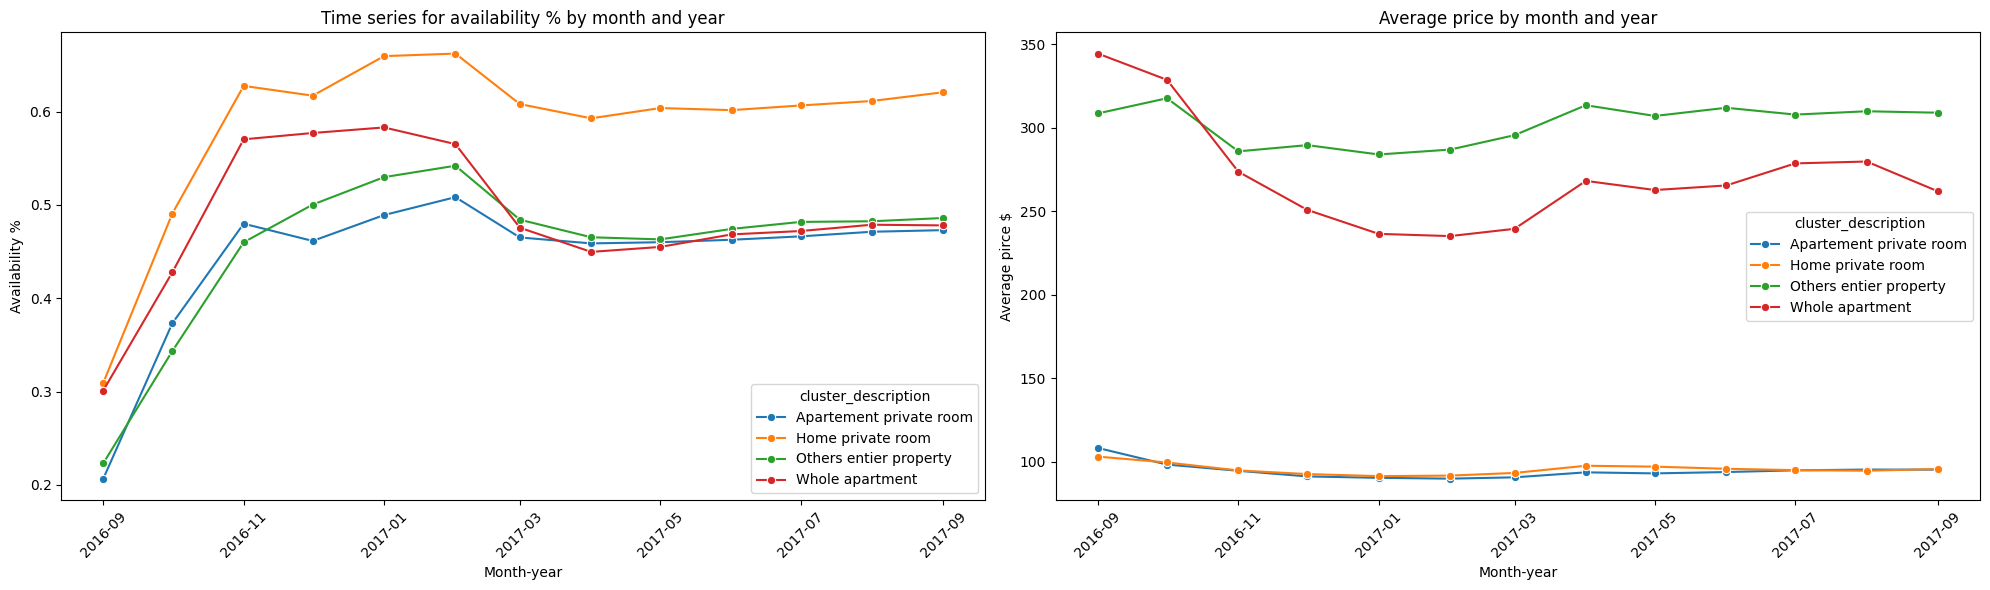

In [85]:

# Crear una figura y ejes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

# Graficar la primera serie en el primer eje
sns.lineplot(data=q3_time_series_df, x='month_year', y='availability_perc', hue='cluster_description', marker='o', ax=ax1)
ax1.set_title('Time series for availability % by month and year')
ax1.set_xlabel('Month-year')
ax1.set_ylabel('Availability %')
ax1.grid(False)

# Graficar la segunda serie en el segundo eje
sns.lineplot(data=q3_time_series_df, x='month_year', y='avg_price', hue='cluster_description', marker='o', ax=ax2)
ax2.set_title('Average price by month and year')
ax2.set_xlabel('Month-year')
ax2.set_ylabel('Average pirce $')
ax2.grid(False)

# Rotar las etiquetas del eje X para ambos gráficos
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# Ajustar el diseño del gráfico
fig.tight_layout()

# Mostrar el gráfico
plt.show()

## Result evaluation

### Question 1

For the quesiton one, we will read the generated vibes description for the neighborhood. It can be cheched the generated descriptions are quite reasonable:

In [86]:
data_dir = '/content/gdrive/MyDrive/neighborhood_vibes.csv'
neighborhood_vibes_df = pd.read_csv(data_dir)

In [87]:
neighborhood_vibes_df

,neighborhood,neighborhood_vibe
0,Downtown,"The vibe of the Downtown neighborhood is lively, vibrant, and convenient. It is a central location with easy access to restaurants, bars, nightlife, public transportation, and various city attractions. The area is bustling with activity, offering plenty of options for entertainment and exploration. With its proximity to popular landmarks and cultural sites, Downtown Boston is a hub of excitement and energy."
1,Bay Village,"The vibe of the Bay Village neighborhood is described as cute, quiet, and quaint, making it a hidden gem and one of the most unique neighborhoods in town. It is known for its local charm, fabulous location, and proximity to wonderful restaurants, cafes, theaters, and parks. The neighborhood is centrally located, offering easy access to public transportation and nearby attractions such as Boston Commons, the Charles River, Copley Square, and the Theatre District. The presence of street gas lamps adds charm to the streets, creating a peaceful and charming atmosphere in the heart of Boston."
2,Beacon Hill,"The vibe of the Beacon Hill neighborhood is one of historical charm, safety, and quaintness. With its rich history, picturesque architecture, and cobblestone streets, Beacon Hill offers a peaceful and serene atmosphere, making you feel like you've traveled back in time to the colonial days. The neighborhood boasts a combination of old-world charm and contemporary amenities, with a variety of local shops, restaurants, and taverns to explore. The proximity to the Boston Common and the Charles River adds to the neighborhood's appeal, providing opportunities for relaxation and learning about American history. Overall, Beacon Hill is a prestigious and desirable neighborhood known for its beauty, rich history, and central location in Boston."
3,South End,"The South End is a trendy, vibrant, and diverse neighborhood known for its historic architecture, charming boutiques, sophisticated eateries, and thriving arts scene. Residents take pride in living here, with owner-operated businesses offering creative offerings. The area is very walkable, with lush trees and flowers lining the streets, creating a European feel. The neighborhood is home to a mix of old and young residents from various backgrounds, making it a culturally rich community. Overall, the South End exudes a lively and welcoming vibe with plenty of local charm and character."
4,Brighton,"The vibe of the Brighton neighborhood is a mix of suburban charm and city convenience. It is a safe and family-friendly area with a diverse selection of cafes, restaurants, and bars to explore. The neighborhood offers easy access to public transportation, making it convenient for residents to travel to different parts of Boston and beyond. With parks, green areas, and proximity to universities like Boston College and Boston University, Brighton is a quiet and scenic residential area with a laid-back atmosphere. Additionally, the neighborhood provides options for dining, shopping, and recreational activities, catering to both locals and visitors."
5,South Boston,"South Boston has a vibrant and lively vibe with a mix of old and new attractions. It offers a true neighborhood feel while being close to downtown and the waterfront, providing easy access to explore the city. The neighborhood boasts a variety of restaurants, bars, coffee shops, and even a beach nearby, making it a desirable location for both locals and visitors. In addition, South Boston is described as having a bustling nightlife, with plenty of options for entertainment, while maintaining a residential feel during the week."
6,Jamaica Plain,"Jamaica Plain is a vibrant, diverse, and eclectic neighborhood with a strong sense of community. It is known for its green spaces, cultural diversity, local restaurants, and artistic influences. The neighborhood offers a mix of urban amenities and a small-town feel, making it a unique and lively place to live or visit."
7,Hyde Par

###Question 2

In order to answer the question 2, we will plot the data based on the previous calculations, in order to generate some insights:

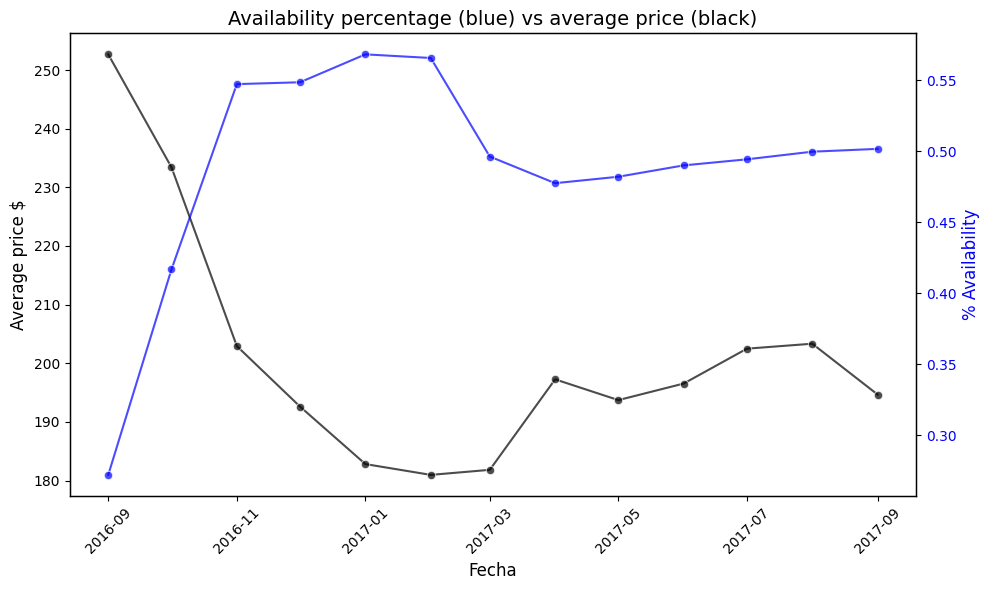

In [88]:
# Seleccionar colores de la paleta de colores de seaborn
orange_color = 'black'
blue_color = 'blue'

# Generar el gráfico con seaborn
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar la primera serie en el primer eje
sns.lineplot(data=q1_time_series_df, x=q1_time_series_df.index, y='avg_price', ax=ax1, color=orange_color, marker='o', alpha=0.7)
ax1.set_xlabel('Fecha', fontsize=12)
ax1.set_ylabel('Average price $', color=orange_color, fontsize=12)
ax1.tick_params(axis='y', labelcolor=orange_color)

# Rotar las etiquetas del eje X
plt.xticks(rotation=45)

# Crear el segundo eje que comparte el mismo eje x
ax2 = ax1.twinx()

# Graficar la segunda serie en el segundo eje
sns.lineplot(data=q1_time_series_df, x=q1_time_series_df.index, y='availability_perc', ax=ax2, color=blue_color, marker='o', alpha=0.7)
ax2.set_ylabel('% Availability', color=blue_color, fontsize=12)
ax2.tick_params(axis='y', labelcolor=blue_color)

# Agregar un título
plt.title('Availability percentage (blue) vs average price (black)', fontsize=14)

# Mejorar la presentación de las leyendas
# fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9), bbox_transform=ax1.transAxes, fontsize=12)

# Agregar un borde negro alrededor del área de trazado
for spine in ax1.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)


# Eliminar el fondo con rayas
ax1.set_facecolor('white')
ax2.set_facecolor('white')

# Eliminar la cuadrícula
ax1.grid(False)
ax2.grid(False)

# Ajustar el diseño del gráfico
fig.tight_layout()

# Mostrar el gráfico
plt.show()

As expected, this reflects the law of supply and demand, the higher the availability, the lower the price. As a note, it seems in September 2016 it occurred some event that left the availability at a minimum.

Excluding this month, the fluctuation seems to be around 20–25$.

### Question 3

To interpretate the clusters, we will use the next function:

In [90]:
kmeans.n_clusters

4

In [92]:
def get_centroids_interpretation(kmeans, columns, scaler):
  """

  Args:
    kmeans: trained kmeans model
    columns: columns for the original data, previous to any normalization
    scaler: scaler used to unnormalize the data
  """
  for index in range(kmeans.n_clusters):
      center = kmeans.cluster_centers_[index].reshape(1, -1)
      original_center = scaler.inverse_transform(kmeans.cluster_centers_[index][[0, 1, 2, 3]].reshape(1, -1))
      center[0][0]  = original_center[0][0]
      center[0][1]  = original_center[0][1]
      center[0][2]  = original_center[0][2]
      center[0][3]  = original_center[0][3]
      for i, column in enumerate(columns):
        print("Column {}, value {}".format(column, center[0][i]))
      print(" ####################################### ")

In [93]:
get_centroids_interpretation(kmeans, listing_chracteristics_norm.columns, scaler)

Column accommodates, value 3.664779161947907
Column bathrooms, value 1.2038505096262733
Column bedrooms, value 1.3346545866364663
Column beds, value 1.786523216308043
Column property_type_Apartment, value 1.0000000000000127
Column property_type_Bed & Breakfast, value -3.677613769070831e-16
Column property_type_Boat, value 9.497611030973019e-17
Column property_type_Camper/RV, value -9.595189226496714e-18
Column property_type_Condominium, value -2.7755575615628914e-17
Column property_type_Dorm, value -1.919037845299343e-17
Column property_type_Entire Floor, value -3.838075690598686e-17
Column property_type_Guesthouse, value -9.595189226496714e-18
Column property_type_House, value 1.4988010832439613e-15
Column property_type_Loft, value 4.597017211338539e-16
Column property_type_Other, value 5.637851296924623e-17
Column property_type_Townhouse, value 6.019490461639521e-16
Column property_type_Villa, value 4.7488055154865094e-17
Column room_type_Entire home/apt, value 1.000000000000011
Colu

We selected the number of cluster taking into account the elbow method for the k-means clustering algorithm and a clear understanding of the clusters, resulting in the identification of four cluster. The technical details can be found in the mentioned above repository.

We used the centroids of the cluster to get an interpretation of the clusters. For example, these are the values for the first one:


As it can be noted, this cluster represents whole apartments with about two real beds and or two bathrooms and some accommodates.

In this line, the four clusters can be thought as:

Whole apartment
A private home room
A private home apartment
Condominium, lofts and other types of listings

In the same way as in the question two, we will generate some plots to compare the time series, including the new cluster dimension:

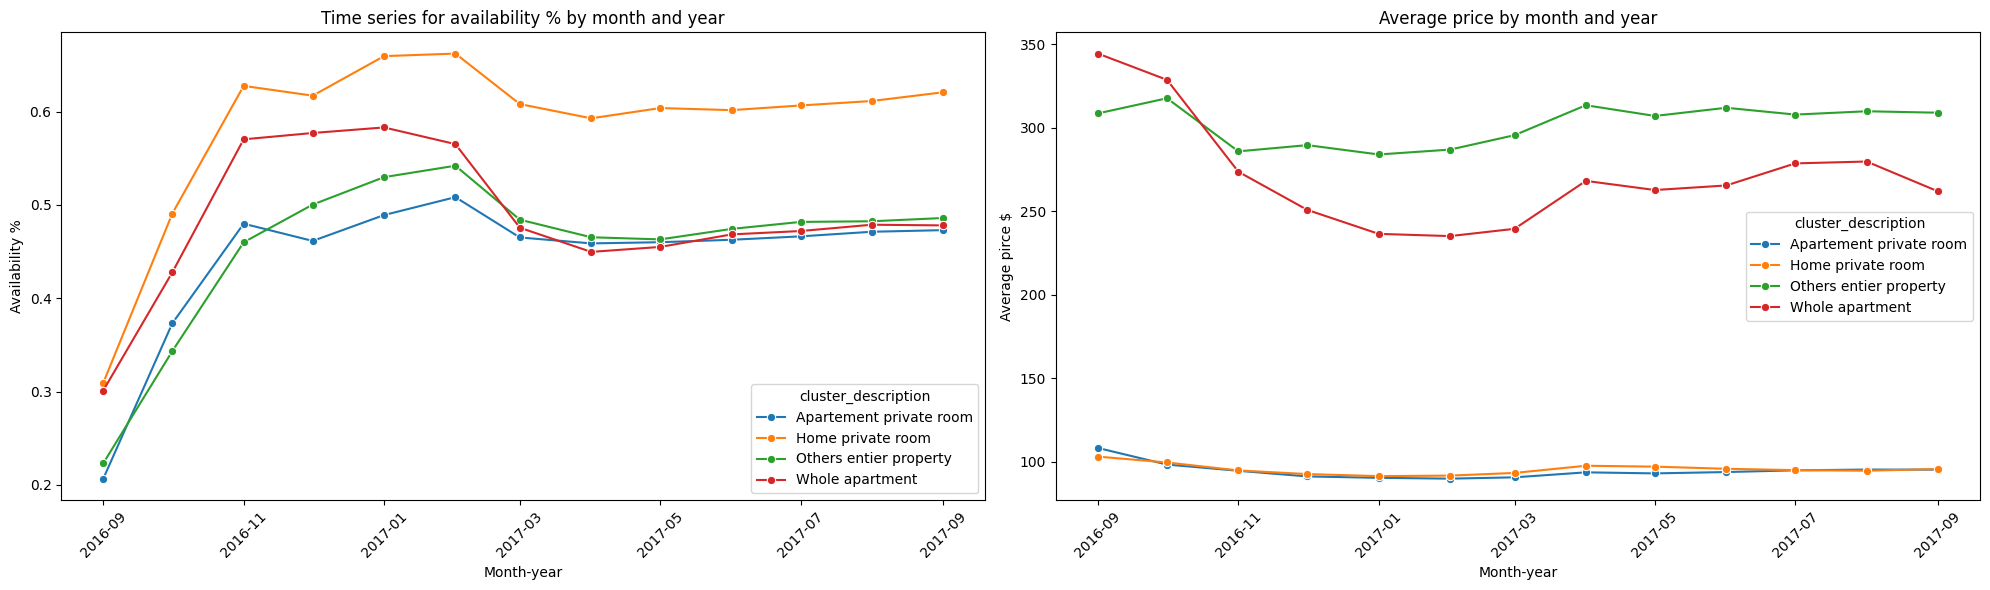

In [89]:
# Crear una figura y ejes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

# Graficar la primera serie en el primer eje
sns.lineplot(data=q3_time_series_df, x='month_year', y='availability_perc', hue='cluster_description', marker='o', ax=ax1)
ax1.set_title('Time series for availability % by month and year')
ax1.set_xlabel('Month-year')
ax1.set_ylabel('Availability %')
ax1.grid(False)

# Graficar la segunda serie en el segundo eje
sns.lineplot(data=q3_time_series_df, x='month_year', y='avg_price', hue='cluster_description', marker='o', ax=ax2)
ax2.set_title('Average price by month and year')
ax2.set_xlabel('Month-year')
ax2.set_ylabel('Average pirce $')
ax2.grid(False)

# Rotar las etiquetas del eje X para ambos gráficos
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# Ajustar el diseño del gráfico
fig.tight_layout()

# Mostrar el gráfico
plt.show()

As it can be noticed, the private room is less prone to price fluctuation, whereas the fluctuation is practically the same for the whole room or apartment, with the difference the prices are generally higher for the apartment, with similar availability conditions.